<a href="https://colab.research.google.com/github/MarinaChau/IASD_classes/blob/master/Part_2_Single_cell_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# Install libraries
!pip install scprep
!pip install tensorflow
!pip install scikit-dimension

# Part 2. Analyses of datasets using unsupervised approach

This is a dataset describing development of a dentate gyrus, a part of the mouse brain. Each object is a brain cell
characterized by the expression of ~10000 genes. The cells are labeled into 24 distinct cell types.

 In this notebook, we will use different libraries to visualize our dataset.

In [ ]:
from google.colab import drive

try:
  drive._mount('/content/drive') 
except Exception:
  drive.mount('/content/drive')


Mounted at /content/drive


In [29]:
## Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import skdim
import io
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
from plotly.subplots import make_subplots
### Third-party libraries

## Exercice
* 1) Choose one of the datasets 1-3 or suggest you own
* 2) Check if you have missing values and suggest a strategy for imputing them
* 3) Check if the dataset needs to be normalized in a particular way
* 4) Give an estimate of intrinsic dimensionality of the dataset (if you want you can use skdim package
* https://github.com/j-bac/scikit-dimension/tree/master/skdim)
* 5) Apply PCA and visualize the dataset in the space of two first principal components
* 6) Investigate higher-order principal components, try to conclude if they contain useful information
* 7) Apply any non-linear manifold learning method and visualize the dataset
* 8) Apply two or more different clustering methods using clustering quality criteria, compare the results as
* well as computational time
* 9) Apply any matrix factorization method which is not PCA, compare it with PCA as well as computational time

In [ ]:
## Q.1 Import dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dentate_gyrus_sample3000.csv to dentate_gyrus_sample3000 (2).csv


In [ ]:
dataframe = pd.read_csv(io.StringIO(uploaded["dentate_gyrus_sample3000.csv"].decode("utf-8")))
dataframe.head()

,label,Tmsb10,Apoe,Mt1,Stmn2,Tuba1a,Stmn1,Meg3,Ptn,Mt3,Tubb2b,Fabp7,Cst3,Xist,Sox11,Tubb3,Pcp4,Igfbpl1,Slc1a2,Slc1a3,Tubb5,Snca,Plp1,Atp1a2,Dbi,Nnat,Cd24a,Mt2,Ppp3ca,Ncdn,Gap43,Mllt11,Marcksl1,Aldoc,Camk2a,Plppr4,Clu,Glul,Ptprz1,Sparcl1,...,Shf,2610037D02Rik,Atxn7l2,Tmem74b,Adnp2,Arsg,Esco2,Tmtc3,Rnmtl1,Pald1,Dcp1a,Gemin2,Nckipsd,Notch3,Ubtd1,Simc1,Nkrf,Gabpb2,Fbxo10,Cenpl,Wdr36,Invs,Trim39,Ttc21b,Penk,Zfp629,D130020L05Rik,Pnpt1,Ice2,Pifo,Nol10,Gm6356,Tpmt,Gba,Slc25a20,Col19a1,Zfp516,Rgp1,Col26a1,Jpx
0,Neuroblast,4.47,0.00,0.35,3.09,4.62,3.72,4.04,0.19,0.19,3.81,0.19,1.43,3.4,2.30,3.01,0.00,0.99,0.00,0.00,3.63,1.58,0.00,0.00,0.49,3.83,2.08,0.19,1.62,0.35,1.88,3.01,3.59,0.19,0.00,0.62,0.00,0.72,0.35,0.00,...,0.0,0.00,0.00,0.19,0.00,0.00,0.0,0.0,0.0,0.0,0.19,0.19,0.0,0.00,0.19,0.0,0.19,0.00,0.19,0.00,0.00,0.19,0.0,0.0,0.0,0.19,0.00,0.00,0.35,0.0,0.19,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.49,0.00
1,Immature-GC,2.36,0.36,0.84,1.40,1.76,0.84,2.36,0.00,2.65,1.29,0.36,1.29,0.0,1.40,0.63,3.27,0.00,1.01,0.00,0.84,2.96,1.01,0.00,0.63,0.63,0.00,0.36,3.54,2.32,0.00,2.68,2.08,0.00,2.44,2.51,0.00,0.00,0.63,1.29,...,0.0,0.00,0.00,0.00,0.63,0.00,0.0,0.0,0.0,0.0,0.00,0.36,0.0,0.00,0.63,0.0,0.00,0.00,0.36,0.00,0.63,0.00,0.0,0.0,0.0,0.00,0.36,0.36,0.00,0.0,0.36,0.0,0.0,0.63,0.00,0.0,0.0,0.36,0.00,0.00
2,GC-juv,1.71,5.08,2.98,0.52,2.95,1.31,0.75,3.97,3.32,1.57,4.53,4.22,0.0,1.18,0.37,0.20,0.75,1.62,3.15,1.37,0.37,0.20,1.92,4.98,2.72,0.37,2.41,1.37,0.00,0.00,0.75,2.23,2.82,0.00,0.52,2.28,1.75,2.35,2.87,...,0.0,0.00,0.00,0.00,0.20,0.00,0.0,0.0,0.0,0.2,0.20,0.00,0.2,0.20,0.00,0.2,0.00,0.00,0.37,0.20,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.2,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.20,0.00,0.00
3,CA3-Pyr,4.29,0.20,0.20,3.35,4.26,3.88,3.82,1.24,0.00,3.52,0.37,1.47,1.1,1.10,2.85,3.23,1.70,0.20,0.00,4.03,1.02,0.00,0.00,1.61,2.90,2.10,0.00,1.17,0.37,3.10,2.84,3.09,0.00,0.00,0.00,0.20,0.51,0.20,0.00,...,0.2,0.20,0.20,0.00,0.00,0.20,0.0,0.2,0.2,0.0,0.00,0.00,0.0,0.00,0.20,0.2,0.00,0.00,0.00,0.00,0.20,0.00,0.2,0.2,0.0,0.00,0.00,0.20,0.00,0.0,0.00,0.2,0.0,0.00,0.20,0.0,0.0,0.00,0.37,0.00
4,GC-juv,1.91,4.08,3.24,0.41,2.67,1.01,1.10,4.69,3.58,1.79,5.36,4.31,0.0,0.41,0.22,1.18,0.22,2.44,3.25,1.79,0.92,0.22,2.83,4.38,1.39,0.81,2.82,1.18,0.00,0.56,0.41,2.44,2.77,0.00,0.22,1.10,2.58,2.83,2.98,...,0.0,0.22,0.22,0.22,0.00,0.22,0.0,0.0,0.0,0.0,0.22,0.00,0.0,0.22,0.41,0.0,0.00,0.22,0.00,0.22,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.22,0.22,0.0,0.0,0.00,0.00,0.41


In [ ]:
dataframe.to_pickle(path="/content/drive/MyDrive/Master 5A/FML/brain_cell_df.pkl")



In [31]:
# Load data from drive
dataframe = pd.read_pickle("/content/drive/MyDrive/Master 5A/FML/brain_cell_df.pkl")

In [ ]:
print(f'Dataset has {dataframe.shape[0]} cells and {dataframe.shape[1]} features')

Dataset has 3000 cells and 10001 features


In [ ]:
dataframe.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 10001 entries, label to Jpx
dtypes: float64(10000), object(1)
memory usage: 228.9+ MB


In [ ]:
print("Number of categories of cell: ",len(dataframe['label'].value_counts()))
dataframe['label'].value_counts()

Number of categories of cell:  24


Immature-Pyr            589
GC-juv                  429
Immature-GC             319
GC-adult                304
Neuroblast              178
Astro-adult             151
Immature-GABA           121
Astro-juv               104
RGL_young                85
MOL                      82
OPC                      81
Immature-Astro           75
Endothelial              74
CA3-Pyr                  65
Cajal-Retzius            61
nIPC-perin               57
MiCajal-Retziusoglia     50
nIPC                     40
NFOL                     33
RGL                      25
VLMC                     22
GABA                     22
Ependymal                19
PVM                      14
Name: label, dtype: int64

# Preparing data

### Q.2 Check if you have missing values and suggest a strategy for imputing them

Helful link: `https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779`

We can either check if there is any missing value for each cell by searching NaN per row or check if there is any missing value per features by checking each row.

It depends on what we want for our dataset. If there are features with a lot of missing elements, we can either impute values or choose to delete that features. As 10 000 is a huge number of features, and we will work on reducing its number, if one feature is missing, we can neglect it (well if we consider each feature having the same weight importance). 

Another solution would be to imput data, however it requires some domain experience.


In [ ]:
# Percentages of missing values
print((dataframe.isnull().mean() * 100).sort_values(ascending = True))

label      0.0
Fam135a    0.0
Abcf2      0.0
Mfsd11     0.0
Ascc1      0.0
          ... 
Dbndd2     0.0
Map2k4     0.0
Chmp2b     0.0
Rassf8     0.0
Jpx        0.0
Length: 10001, dtype: float64


There is no missing values in our dataset.


**What we can say:**

There are three main types of missing data:
- Missing completely at random (MCAR) : These are the missing data points that follow no discernable pattern.
- Missing at random (MAR) : The missing value can roughly be interpolated from the remaining values to a reasonable degree of accuracy.  If conditioning on another feature increases the likelihood of a particular value compared to a proportional distribution, this value is likely MAR.
- Not missing at random (NMAR): data where the mechanism for why the data is missing is known. Still, the values can not effectively be inferred or predicted.

**How we would replace the missing values:**

Each possible solution depends on the use case. 
- If there is a lot of missing data for one feature, as we have 10000 features and we suppose that each feature has the same importance weight and are not strongly correlated with each other, best would be to drop this feature. Replacing missing data by statistics such as mean, median, max or min would induce bias and won't factor the correlations between features, it only works on the column level. 
- If there is some MCAR data, as each cell belongs to one of the 24 categories, we could group the cells by its categories, and then try to do some imputation using k-NN. The k nearest neighbours is an algorithm that is used for simple classification. The algorithm uses ‘feature similarity’ to predict the values of any new data points. This means that the new point is assigned a value based on how closely it resembles the points in the training set. However it can be quite sensitive to outliers in the data.
- We can also work with the MICE procedure: MICE is a multiple imputation method used to replace missing data values in a data set under certain assumptions about the data missingness mechanism (e.g., the data are missing at random, the data are missing completely at random).


### Q.3 Check if the dataset needs to be normalized in a particular way

Helpful link: 
- `https://towardsdatascience.com/how-to-normalize-single-cell-a438281ea654`
- `https://towardsdatascience.com/tagged/stats-ml-life-sciences`
- `https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/`
- `https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff`
- `https://www.machinecurve.com/index.php/2020/11/23/feature-scaling-with-python-and-sparse-data/`

In [ ]:
# Does the data need to be normalized? 

dataframe.iloc[:,1:].max().sort_values(ascending=False)

Malat1     7.70
Plp1       7.44
Cst3       7.29
Ttr        7.17
Ptgds      7.15
           ... 
Ppwd1      0.76
Nle1       0.76
Tmem74b    0.75
Gba        0.75
Pgm3       0.72
Length: 10000, dtype: float64

In [ ]:
col_ranges = dataframe.iloc[:,1:].max() - dataframe.iloc[:,1:].min() # Looking at the data range for each feature
print((col_ranges.sort_values(ascending=False)))

Plp1       7.44
Malat1     7.33
Cst3       7.29
Ttr        7.17
Ptgds      7.15
           ... 
Ppwd1      0.76
Nle1       0.76
Tmem74b    0.75
Gba        0.75
Pgm3       0.72
Length: 10000, dtype: float64


In [ ]:
dataframe.iloc[:,1:].std() # Checking the standard variation of our data

Tmsb10     1.662372
Apoe       1.469267
Mt1        1.467278
Stmn2      1.436146
Tuba1a     1.419872
             ...   
Col19a1    0.131733
Zfp516     0.139209
Rgp1       0.144421
Col26a1    0.142950
Jpx        0.140936
Length: 10000, dtype: float64

We can see that features in our dataset have different range, going from 0.72 for Pgm3 (the smallest range) to 7.44 for Plp1. It is quite large (x10 factor) and implies that some features will definitly outweight others. Even the standard variation difference between data is important.

There are plenty of methods to "normalize our data" but the two principals are: either we normalize it, or we standardize it. 

- Standard Scaler- Transforms features independently to unit variance and zero centered.Its data value range is fixed between 0 and 1 . Most commonly used.
- MInMax Scaler - Alternate to standard scaling which has agility to set the minimum and maximum range of data value. e.g. -1 to +1, -10 to +10
Min max scaler should be used when it is required to capture small variance in features and also for sparse data where zero value needs to be preserved.

In [ ]:
dataframe.head()

,label,Tmsb10,Apoe,Mt1,Stmn2,Tuba1a,Stmn1,Meg3,Ptn,Mt3,Tubb2b,Fabp7,Cst3,Xist,Sox11,Tubb3,Pcp4,Igfbpl1,Slc1a2,Slc1a3,Tubb5,Snca,Plp1,Atp1a2,Dbi,Nnat,Cd24a,Mt2,Ppp3ca,Ncdn,Gap43,Mllt11,Marcksl1,Aldoc,Camk2a,Plppr4,Clu,Glul,Ptprz1,Sparcl1,...,Shf,2610037D02Rik,Atxn7l2,Tmem74b,Adnp2,Arsg,Esco2,Tmtc3,Rnmtl1,Pald1,Dcp1a,Gemin2,Nckipsd,Notch3,Ubtd1,Simc1,Nkrf,Gabpb2,Fbxo10,Cenpl,Wdr36,Invs,Trim39,Ttc21b,Penk,Zfp629,D130020L05Rik,Pnpt1,Ice2,Pifo,Nol10,Gm6356,Tpmt,Gba,Slc25a20,Col19a1,Zfp516,Rgp1,Col26a1,Jpx
0,Neuroblast,4.47,0.00,0.35,3.09,4.62,3.72,4.04,0.19,0.19,3.81,0.19,1.43,3.4,2.30,3.01,0.00,0.99,0.00,0.00,3.63,1.58,0.00,0.00,0.49,3.83,2.08,0.19,1.62,0.35,1.88,3.01,3.59,0.19,0.00,0.62,0.00,0.72,0.35,0.00,...,0.0,0.00,0.00,0.19,0.00,0.00,0.0,0.0,0.0,0.0,0.19,0.19,0.0,0.00,0.19,0.0,0.19,0.00,0.19,0.00,0.00,0.19,0.0,0.0,0.0,0.19,0.00,0.00,0.35,0.0,0.19,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.49,0.00
1,Immature-GC,2.36,0.36,0.84,1.40,1.76,0.84,2.36,0.00,2.65,1.29,0.36,1.29,0.0,1.40,0.63,3.27,0.00,1.01,0.00,0.84,2.96,1.01,0.00,0.63,0.63,0.00,0.36,3.54,2.32,0.00,2.68,2.08,0.00,2.44,2.51,0.00,0.00,0.63,1.29,...,0.0,0.00,0.00,0.00,0.63,0.00,0.0,0.0,0.0,0.0,0.00,0.36,0.0,0.00,0.63,0.0,0.00,0.00,0.36,0.00,0.63,0.00,0.0,0.0,0.0,0.00,0.36,0.36,0.00,0.0,0.36,0.0,0.0,0.63,0.00,0.0,0.0,0.36,0.00,0.00
2,GC-juv,1.71,5.08,2.98,0.52,2.95,1.31,0.75,3.97,3.32,1.57,4.53,4.22,0.0,1.18,0.37,0.20,0.75,1.62,3.15,1.37,0.37,0.20,1.92,4.98,2.72,0.37,2.41,1.37,0.00,0.00,0.75,2.23,2.82,0.00,0.52,2.28,1.75,2.35,2.87,...,0.0,0.00,0.00,0.00,0.20,0.00,0.0,0.0,0.0,0.2,0.20,0.00,0.2,0.20,0.00,0.2,0.00,0.00,0.37,0.20,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.2,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.20,0.00,0.00
3,CA3-Pyr,4.29,0.20,0.20,3.35,4.26,3.88,3.82,1.24,0.00,3.52,0.37,1.47,1.1,1.10,2.85,3.23,1.70,0.20,0.00,4.03,1.02,0.00,0.00,1.61,2.90,2.10,0.00,1.17,0.37,3.10,2.84,3.09,0.00,0.00,0.00,0.20,0.51,0.20,0.00,...,0.2,0.20,0.20,0.00,0.00,0.20,0.0,0.2,0.2,0.0,0.00,0.00,0.0,0.00,0.20,0.2,0.00,0.00,0.00,0.00,0.20,0.00,0.2,0.2,0.0,0.00,0.00,0.20,0.00,0.0,0.00,0.2,0.0,0.00,0.20,0.0,0.0,0.00,0.37,0.00
4,GC-juv,1.91,4.08,3.24,0.41,2.67,1.01,1.10,4.69,3.58,1.79,5.36,4.31,0.0,0.41,0.22,1.18,0.22,2.44,3.25,1.79,0.92,0.22,2.83,4.38,1.39,0.81,2.82,1.18,0.00,0.56,0.41,2.44,2.77,0.00,0.22,1.10,2.58,2.83,2.98,...,0.0,0.22,0.22,0.22,0.00,0.22,0.0,0.0,0.0,0.0,0.22,0.00,0.0,0.22,0.41,0.0,0.00,0.22,0.00,0.22,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.22,0.22,0.0,0.0,0.00,0.00,0.41


#### Check dataset sparsity

In [ ]:
# Count the number of zero per column to see how sparse our dataset is (%)
print(dataframe.iloc[:, 1:].astype(bool).sum(axis=0) / dataframe.shape[0] *100)

# Check the sparsity of our matrix
sparr = dataframe.iloc[:, 1:].to_numpy()
print("sparsity:", (sparr == 0).mean())

Tmsb10     94.633333
Apoe       87.700000
Mt1        90.766667
Stmn2      81.400000
Tuba1a     99.200000
             ...    
Col19a1    13.533333
Zfp516     24.866667
Rgp1       34.266667
Col26a1    14.000000
Jpx        31.733333
Length: 10000, dtype: float64
sparsity: 0.39000076666666667


Our dataset is quite sparse (40% of the data is equals to 0).

In [33]:
# Separating labels from data
df = dataframe.iloc[:, 1:].copy()


# Standardizing our data
scaler = StandardScaler() 
data_scaled = scaler.fit_transform(df)

#### Encoding labels with ordinal categories

In [61]:
from sklearn.preprocessing import OrdinalEncoder

cell_labels = dataframe[["label"]]
encoder = OrdinalEncoder()
cell_label_encoded = encoder.fit_transform(cell_labels)
cell_label_encoded

array([[16.],
       [11.],
       [ 8.],
       ...,
       [11.],
       [ 8.],
       [10.]])

In [62]:
encoder.categories_

[array(['Astro-adult', 'Astro-juv', 'CA3-Pyr', 'Cajal-Retzius',
        'Endothelial', 'Ependymal', 'GABA', 'GC-adult', 'GC-juv',
        'Immature-Astro', 'Immature-GABA', 'Immature-GC', 'Immature-Pyr',
        'MOL', 'MiCajal-Retziusoglia', 'NFOL', 'Neuroblast', 'OPC', 'PVM',
        'RGL', 'RGL_young', 'VLMC', 'nIPC', 'nIPC-perin'], dtype=object)]

In [34]:
df.astype(bool).sum(axis=0)

Tmsb10     2839
Apoe       2631
Mt1        2723
Stmn2      2442
Tuba1a     2976
           ... 
Col19a1     406
Zfp516      746
Rgp1       1028
Col26a1     420
Jpx         952
Length: 10000, dtype: int64

In [35]:
print("mean:", data_scaled.mean(axis=0))
print("std:", data_scaled.std(axis=0))

mean: [ 3.11454566e-16 -2.81256500e-17 -5.74355378e-17 ... -5.86197757e-17
  7.10542736e-18 -6.33567273e-17]
std: [1. 1. 1. ... 1. 1. 1.]


We decided to use Standard Scalar over Min max as it will not lower the variance like MinMax (useful when using PCA). Moreover, we will consider the effect of outliers important, as we want to visualize the data, thus keeping the standard scalar normalization.

However, our dataset is quite sparse (around 40% data). Using traditional scaling methods aren't the best solution in this case. Indeed, both of these methods will make the center shift and will "break" the sparsity.

We can use instead **MaxAbsScalar**.

Scale each feature by its maximum absolute value. This estimator scales and translates each feature individually such that the maximal absolute value of each feature in the training set will be 1.0. It does not shift/center the data, and thus does not destroy any sparsity.


In [36]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
data_scaled = scaler.fit_transform(df)
standardized_dataset = scaler.transform(df)
print(standardized_dataset)

[[0.83395522 0.         0.05376344 ... 0.         0.2816092  0.        ]
 [0.44029851 0.05454545 0.12903226 ... 0.47368421 0.         0.        ]
 [0.31902985 0.76969697 0.4577573  ... 0.26315789 0.         0.        ]
 ...
 [0.         0.17575758 0.32104455 ... 0.         0.         0.        ]
 [0.76865672 0.0469697  0.02611367 ... 0.22368421 0.17816092 0.        ]
 [0.92910448 0.02424242 0.         ... 0.21052632 0.         0.        ]]


We are preserving the sparsity of our dataset.

### Q.4 Give an estimate of intrinsic dimensionality of the dataset

#### **What is intrinsic dimension ?**

Datasets available today frequently have a large number of features and are thus said to be high-dimensional. However many of these features are usually redundant, for example because of linear or non-linear correlations. In such a case it is possible to describe a dataset using a lower number of features. The notion of intrinsic dimension (ID) intuitively **refers to the minimal number of features needed to represent a dataset with little information loss.**

In the context of the *manifold hypothesis*, i.e., the hypothesis that data are sampled from an underlying n-dimensional manifold, the goal of ID estimation is to recover n. Global estimators of ID are based on this hypothesis and return a single estimated dimension for the whole dataset.

When a dataset contains multiple manifolds or regions with different dimensionality (e.g., imagine sampling a line and a sphere and joining them as one dataset), they should be explored using local estimators. The idea behind local ID estimation is to operate in local neighborhoods of each point, where a manifold can be well approximated by its flat tangent space. These local pieces of data are assumed to be close to a uniformly distributed n-dimensional ball. In this package, local datasets are simply defined using the k-nearest neighbours of each point, and an ID value is thus returned for each datapoint. Such an approach also allows one to repurpose global estimators as local estimators by applying them in each local neighborhood.

In [37]:
pca=skdim.id.lPCA()

#global ID
gid1=pca.fit(standardized_dataset).dimension_
print(gid1)


12


In [39]:
#local ID (pointwise estimates)
lid1=pca.fit_pw(standardized_dataset, n_neighbors=25).dimension_pw_


In [46]:
lid1

array([23, 24, 23, ..., 13, 24, 24])

### Q.5  Apply PCA and visualize the dataset in the space of two first principal components

Helpful link: `https://stackabuse.com/dimensionality-reduction-in-python-with-scikit-learn/`

#### Checking PCA variance for all of the features

In [47]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit_transform(standardized_dataset)
pca_variance = pca.explained_variance_

In [50]:
pca_variance.shape

(3000,)

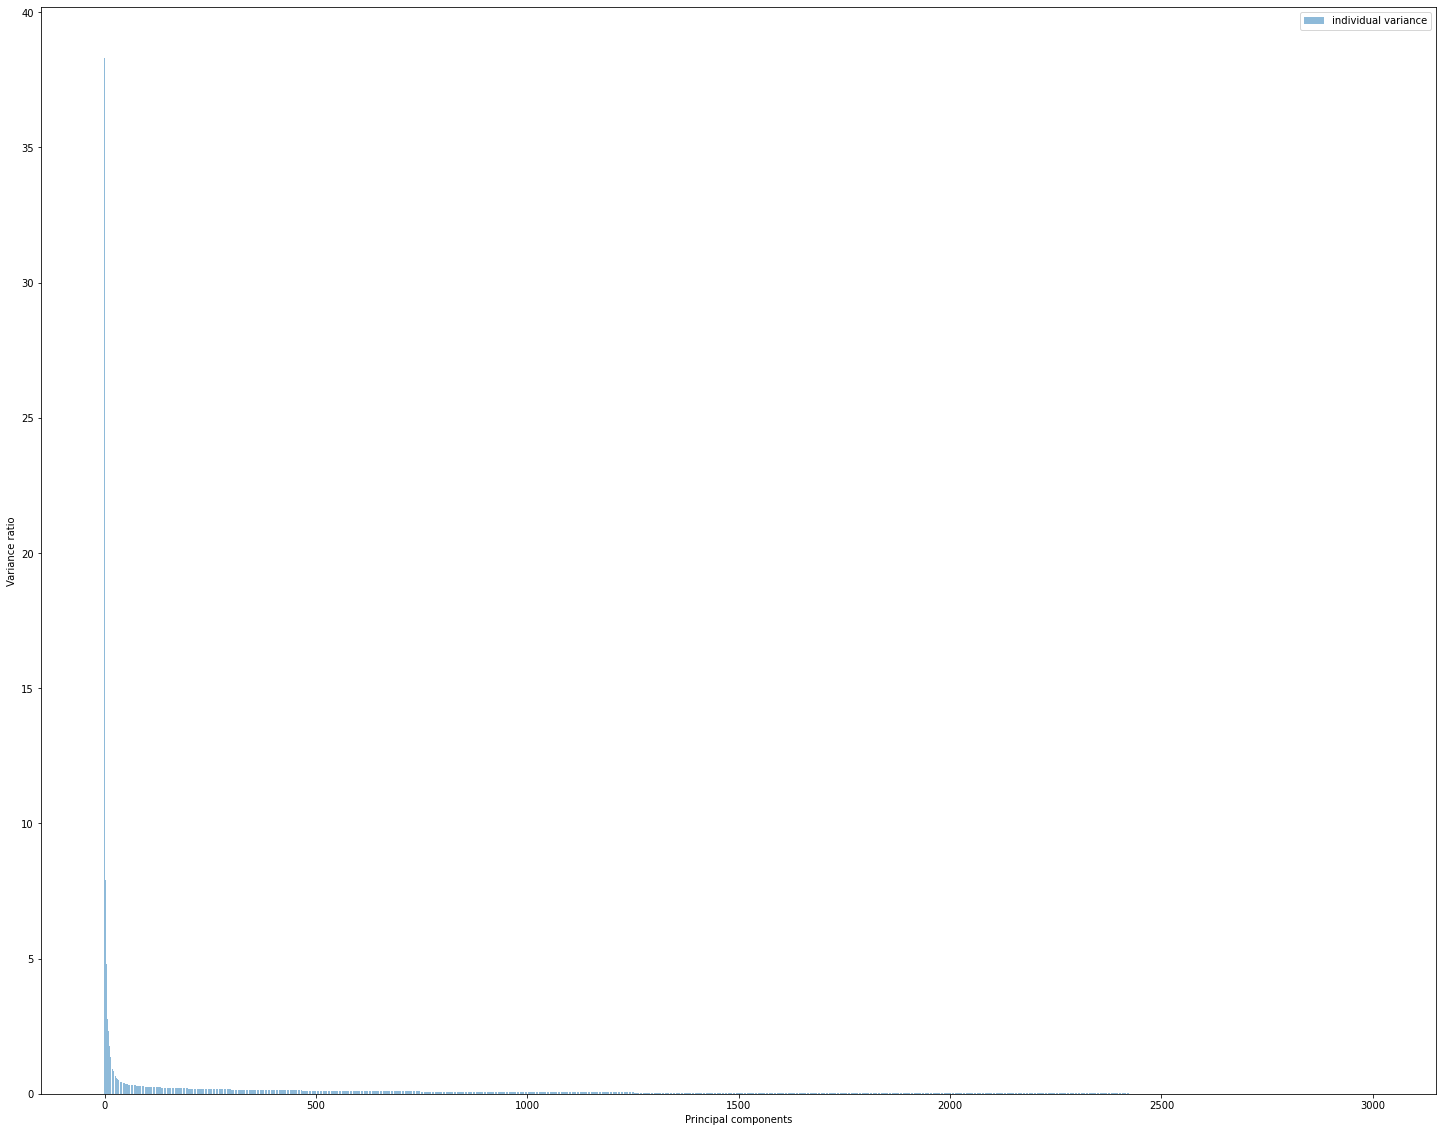

In [56]:
%matplotlib inline
plt.figure(figsize=(25, 20))
plt.bar(range(3000), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

#### Checking with the two first PCA components

In [90]:
# with the two first principal components
pca2 = PCA(n_components=2)
pca2.fit(standardized_dataset)
x_2d = pca2.transform(standardized_dataset)



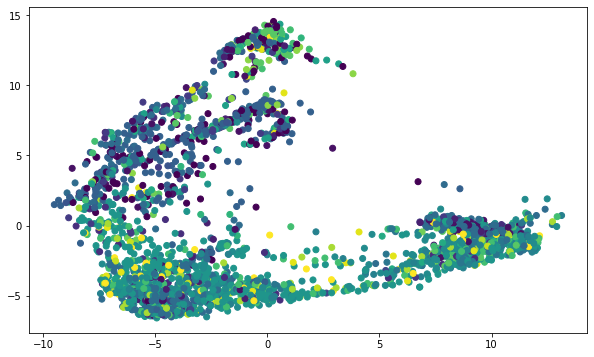

In [82]:
plt.figure(figsize=(10,6))
plt.scatter(x_2d[:,0], x_2d[:,1], c=cell_label_encoded)
plt.show()

### Q.6 Investigate higher-order principal components, try to conclude if they contain useful information

In [85]:
# with the 12 first principal components (12 being the global ID found earlier with skdim)
pca3 = PCA(n_components=12)
pca3.fit(standardized_dataset)
x_3d = pca3.transform(standardized_dataset)


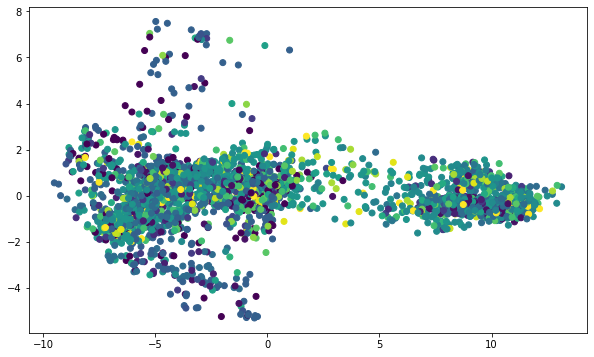

In [84]:
plt.figure(figsize=(10,6))
plt.scatter(x_3d[:,0], x_3d[:,11], c=cell_label_encoded)
plt.show()

In [86]:
# with the 30 first principal components 
pca4 = PCA(n_components=30)
pca4.fit(standardized_dataset)
x_4d = pca4.transform(standardized_dataset)


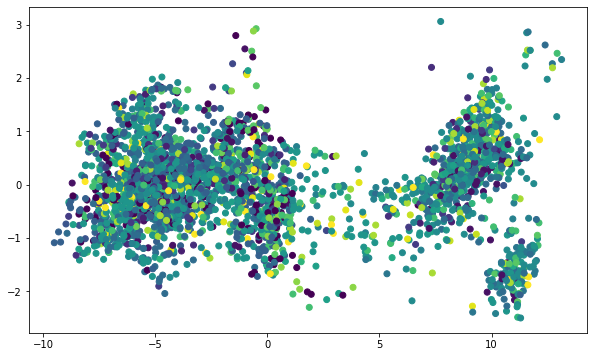

In [89]:
plt.figure(figsize=(10,6))
plt.scatter(x_4d[:,0], x_4d[:,25], c=cell_label_encoded)
plt.show()

We can notice that going from the top 2 components to the top 12 changes a lot the data space. Two is not enough to represent the data.

Useful link: `https://towardsdatascience.com/pca-102-should-you-use-pca-how-many-components-to-use-how-to-interpret-them-da0c8e3b11f0`

### Q.7 Apply any non-linear manifold learning method and visualize the dataset

Helpful link: 
- `https://duchesnay.github.io/pystatsml/machine_learning/manifold.html`
- `https://coderzcolumn.com/tutorials/machine-learning/scikit-learn-sklearn-manifold-learning`
- `https://towardsdatascience.com/manifold-learning-t-sne-lle-isomap-made-easy-42cfd61f5183`

#### IsoMap

Isomap seeks a lower-dimensional representation that maintains ‘geodesic distances’ between the points. A **geodesic distance is a generalization of distance for curved surfaces**. Hence, instead of measuring distance in pure Euclidean distance with the Pythagorean theorem-derived distance formula, Isomap optimizes distances along a discovered manifold.

In [96]:
from sklearn.manifold import Isomap

embedding = Isomap(n_components=2) #resulting data has 2 dimensions, 'components'
X_transformed = embedding.fit_transform(standardized_dataset) #fit model and transform

In [95]:
X_transformed

array([[-39.44284033, -73.37484445,   4.40178939, ..., -16.13336103,
         -3.826493  ,   8.00561334],
       [ 82.40504883,   2.9090228 ,   6.28050935, ...,   0.58564523,
         -0.94605124,  -0.49996556],
       [-60.2045287 ,  44.26597677, -10.67113926, ..., -21.06932715,
         -7.85951029, -14.0541496 ],
       ...,
       [119.70592008,  -7.39347461,  16.64364397, ...,  -1.60767363,
         37.32802437,  27.77855974],
       [-55.55873843,  12.48262855,  17.61179319, ..., -24.28033127,
         -0.97266049,   1.33691184],
       [-44.94242785, -18.39486858,  -3.99023163, ...,   4.77277329,
          7.17723088,  -5.69926127]])

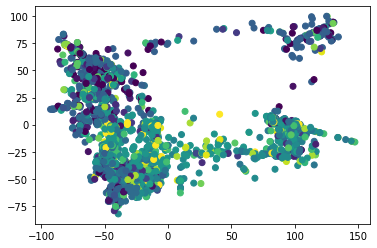

In [97]:
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=cell_label_encoded)

### Locally Linear Embedding

Locally Linear Embeddings use a variety of tangent linear patches to model a manifold. It can be thought of as performing a PCA on each of these neighborhoods locally, producing a linear hyperplane, then comparing the results globally to find the best nonlinear embedding. The goal of LLE is to ‘unroll’ or ‘unpack’ in distorted fashion the structure of the data, so often LLE will tend to have a high density in the center with extending rays.

In [98]:
from sklearn.manifold import LocallyLinearEmbedding
embedding = LocallyLinearEmbedding(n_components=2) #result has 2 dimensions
X_transformed = embedding.fit_transform(standardized_dataset)

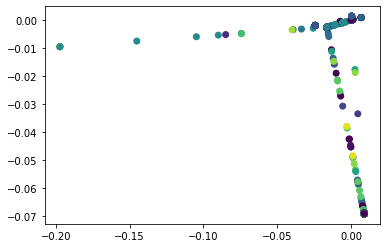

In [99]:
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=cell_label_encoded)

#### t-SNE

t-SNE is one of the most popular choices for high-dimensional visualization, and stands for t-distributed Stochastic Neighbor Embeddings. The algorithm converts relationships in original space into t-distributions, or normal distributions with small sample sizes and relatively unknown standard deviations. This makes t-SNE very sensitive to the local structure, a common theme in manifold learning. It is considered to be the go-to visualization method because of many advantages it possesses:

- It is able to reveal the structure of the data at many scales.
- It reveals data that lies in multiple manifolds and clusters
- Has a smaller tendency to cluster points at the center.

**Isomap and LLE are best use to unfold a single, continuous, low-dimensional manifold**. On the other hand, **t-SNE focuses on the local structure of the data and attempts to ‘extract’ clustered local groups instead of trying to ‘unroll’ or ‘unfold’ it.** This gives t-SNE an upper hand in detangling high-dimensional data with multiple manifolds. It is trained using gradient descent and tries to minimize entropy between distributions. In this sense, it is almost like a simplified, unsupervised neural network.


t-SNE is very powerful because of this ‘clustering’ vs. ‘unrolling’ approach to manifold learning. With a high-dimensional and multiple-manifold dataset like MNIST, where rotations and shifts cause nonlinear relationships, t-SNE performs even better than LDA, which was given the labels.

In [100]:
from sklearn.manifold import TSNE
embedding = TSNE(n_components=2) #result has 2 features
X_transformed = embedding.fit_transform(standardized_dataset)



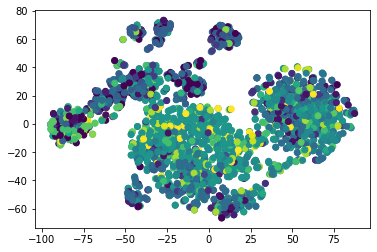

In [101]:
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=cell_label_encoded)

### Q.8  Apply two or more different clustering methods using clustering quality criteria, compare the results as well as computational time

### Q.9 Apply any matrix factorization method which is not PCA, compare it with PCA as well as computational time